In [1]:
import pyspark 
from pyspark import SQLContext

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from unidecode import unidecode

from nltk.tokenize import TweetTokenizer

from wordcloud import WordCloud 

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

import numpy as np

## Criação do contexto do Spark e obtenção dos dados no HDFS utilizando sintaxe HQL

In [2]:
conf = pyspark.SparkConf()
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = SQLContext(sc)

In [3]:
df_load = sqlcontext.sql("select id, `user`.screen_name, text, `user`.location, created_at from load_tweets").toPandas()

In [4]:
df_load.count()

id             1374597
screen_name    1374597
text           1374597
location        886003
created_at     1374597
dtype: int64

In [5]:
df_load.to_csv('base_total.csv')

In [6]:
period_list = pd.to_datetime(df_load.created_at).dt.date.unique()

In [7]:
for d in period_list:
    print(d.strftime('%d/%m/%Y'))

28/02/2021
13/03/2021
14/03/2021
15/03/2021
16/03/2021
17/03/2021
18/03/2021
19/03/2021


## Funções Auxiliares

In [8]:
!pip install nltk

In [9]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/hadoop/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package

[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to /home/hadoop/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package verbnet to
[nltk_data]    |     /home/hadoop/nltk_data...
[nltk_data]    |   Packa

True

In [10]:
def remove_links(df):
    pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))';
    return df.replace(pattern, '', regex=True)

In [11]:
def only_letters(df):
    df = to_lowercase(df)
    df = remove_accentuation(df)
    return df.replace('[^a-zA-Z\\s]', '', regex=True)

In [6]:
portuguese_stops = stopwords.words('portuguese')

def remove_stopwords(df):
    return df.apply(lambda tweet: ' '.join([word for word in tweet.split() if word not in (portuguese_stops)]))

In [13]:
def to_lowercase(df):
    return df.apply(lambda tweet: tweet.strip().lower())

In [14]:
def remove_accentuation(df):
    return df.apply(lambda tweet: unidecode(tweet))

In [15]:
def remove_small_content(df):
    return df.apply(lambda tweet: ' '.join([word for word in tweet.split() if len(word)>=3]))

## Filtro dos dados no qual o texto publicado inicia com "RT" (Retweets) 

In [16]:
df_load_dirt = df_load[df_load.text.str.startswith('RT')]

In [17]:
df_load_dirt.head(5)

,id,screen_name,text,location,created_at
0,1366032532014309379,Leandrocoelhod5,"RT @blogdopannunzio: Olhaí, @jairbolsonaro . S...",None,Sun Feb 28 14:28:29 +0000 2021
2,1366032533524262912,SantosOlszewski,RT @hilde_angel: A mudança do embaixador de Is...,None,Sun Feb 28 14:28:30 +0000 2021
3,1366032533771735044,VXCarmo,RT @guilherme_amado: Senadores de oito partido...,"Ponta Grossa, Brasil",Sun Feb 28 14:28:30 +0000 2021
6,1366032537701781505,gustacioli,RT @AndreiaSadi: Brasil: Quando seguir protoco...,"São Paulo, Brasil",Sun Feb 28 14:28:31 +0000 2021
7,1366032539002023943,LLLGCR,RT @DouglasGarcia: Fechamento de comércio não ...,None,Sun Feb 28 14:28:31 +0000 2021


In [18]:
df_load.count()

id             1374597
screen_name    1374597
text           1374597
location        886003
created_at     1374597
dtype: int64

In [19]:
df_load_dirt.count()

id             913469
screen_name    913469
text           913469
location       575734
created_at     913469
dtype: int64

## Tratamento da coluna "location" e criação da coluna "city" com dados validados

In [20]:
df_load_cleaned = df_load[~df_load.text.str.startswith('RT')]

In [21]:
df_load_cleaned

,id,screen_name,text,location,created_at
1,1366032533184524289,OtaviodeCarval9,Não esqueçam a nova concepção da OMS SOBRE CON...,None,Sun Feb 28 14:28:30 +0000 2021
4,1366032534539231235,cariricoutoSCFC,A desgraça da Covid volta com toda força em Re...,Recife,Sun Feb 28 14:28:30 +0000 2021
5,1366032536145649665,Bernard19783857,Acabei de ver um vídeo de políticos de Maria d...,Bloqueado pelo Presidente,Sun Feb 28 14:28:30 +0000 2021
9,1366032540256116745,JuliaDuarte000,Dia propício pra beber até o covid acabar,"Minas Gerais, Brasil",Sun Feb 28 14:28:31 +0000 2021
10,1366032540096733186,CamilaP65174816,Esse mofino presume q governadores e prefeitos...,None,Sun Feb 28 14:28:31 +0000 2021
...,...,...,...,...,...
1374586,1373036831919501312,chaexplict,minha mãe vai fazer o teste de covid eu tô com...,None,Fri Mar 19 22:21:05 +0000 2021
1374587,1373036833009979395,thammoreno,Agora mais do que nunca estou com ódio da covi...,None,Fri Mar 19 22:21:05 +0000 2021
1374588,1373036834922582023,carolmarttire,😥😥 gente tô ficando com muito mais medo da cov...,"Puerto Nuevo, Puerto Rico",Fri Mar 19 22:21:05 +0000 2021
1374591,1373036838068359176,eleuienei,eu tô chocada real porque parei pra pesquisar ...,None,Fri Mar 19 22:21:06 +0000 2021


In [22]:
df_processed = df_load_cleaned.copy()

In [23]:
df_cities = df_processed['location'].str.split(',').str[0]

In [24]:
df_processed['city'] = df_cities.str.upper().copy()

## Obtendo os dados com as informações das cidades Brasileiras

In [25]:
df_cities = pd.read_csv("data/BrazilianCities.csv")
cities_list = df_cities["Cidade"].values.tolist();

In [26]:
df_processed['validated_city'] = df_processed['city'].apply(lambda city: city if city in cities_list else None).copy()

In [27]:
# Total de cidades contabilizadas
df_processed['validated_city'].count()

145051

In [28]:
s_result = df_processed['validated_city'].value_counts().head(5)

In [29]:
s_result

SÃO PAULO         22657
RIO DE JANEIRO    15798
BELO HORIZONTE     6472
BRASÍLIA           5697
PORTO ALEGRE       4779
Name: validated_city, dtype: int64

<AxesSubplot:title={'center':'Most Frequently'}, ylabel='validated_city'>

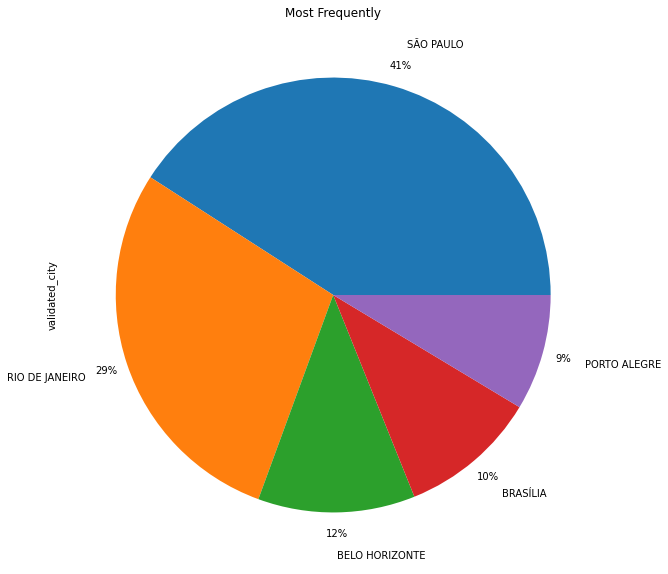

In [30]:
s_result.plot(title="Most Frequently", figsize=(20,10), autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, kind='pie')

## Tratamento dos Dados

In [31]:
df_tweets = df_processed.copy()

In [32]:
df_tweets['text']

1          Não esqueçam a nova concepção da OMS SOBRE CON...
4          A desgraça da Covid volta com toda força em Re...
5          Acabei de ver um vídeo de políticos de Maria d...
9                  Dia propício pra beber até o covid acabar
10         Esse mofino presume q governadores e prefeitos...
                                 ...                        
1374586    minha mãe vai fazer o teste de covid eu tô com...
1374587    Agora mais do que nunca estou com ódio da covi...
1374588    😥😥 gente tô ficando com muito mais medo da cov...
1374591    eu tô chocada real porque parei pra pesquisar ...
1374596    É bizarro ver que nos dias de hoje ainda tem g...
Name: text, Length: 461128, dtype: object

In [33]:
df_tweets['text'] = remove_stopwords(df_tweets['text'])
df_tweets['text'] = remove_links(df_tweets['text'])
df_tweets['text'] = only_letters(df_tweets['text'])
df_tweets['text'] = remove_small_content(df_tweets['text'])

In [34]:
## Removendo todos os tweets vazios após tratamento
df_tweets = df_tweets[df_tweets['text'].str.len() > 0]

In [35]:
df_tweets['text']

1          nao esquecam nova concepcao oms sobre confinam...
4          desgraca covid volta toda forca recife onde va...
5          acabei ver video politicos maria falando vao a...
9                        dia propicio pra beber covid acabar
10         esse mofino presume governadores prefeitos faz...
                                 ...                        
1374586                       mae vai fazer teste covid medo
1374587                 agora nunca odio covid quero ver meu
1374588                       gente ficando medo covid antes
1374591    chocada real porque parei pra pesquisar agora ...
1374596    bizarro ver dias hoje ainda gente acha terra p...
Name: text, Length: 460755, dtype: object

## Palavras mais frequentes

In [22]:
tt = TweetTokenizer()

In [21]:
def get_most_frequently(df):
    df_tweets_tokenized = tt.tokenize(" ".join(tweet for tweet in df))
    df_tweets_tokenized = [word for word in df_tweets_tokenized if len(word)>3]
    most_frequently = FreqDist(df_tweets_tokenized)
    return most_frequently.most_common(10)

## Wordcloud

In [38]:
most_frequently = get_most_frequently(df_tweets['text'])

In [39]:
most_frequently

[('covid', 236635),
 ('corona', 43661),
 ('brasil', 20591),
 ('gente', 18311),
 ('contra', 18025),
 ('mortes', 17926),
 ('pessoas', 16631),
 ('deus', 13960),
 ('vacina', 13496),
 ('hoje', 12936)]

In [40]:
df_tweets_joined = ' '.join(df_tweets['text'])

In [41]:
wordcloud = WordCloud(stopwords=portuguese_stops,
                      background_color='black', width=1920,                            
                      height=1080).generate(df_tweets_joined)

Text(0.5, 1.0, 'Wordcloud')

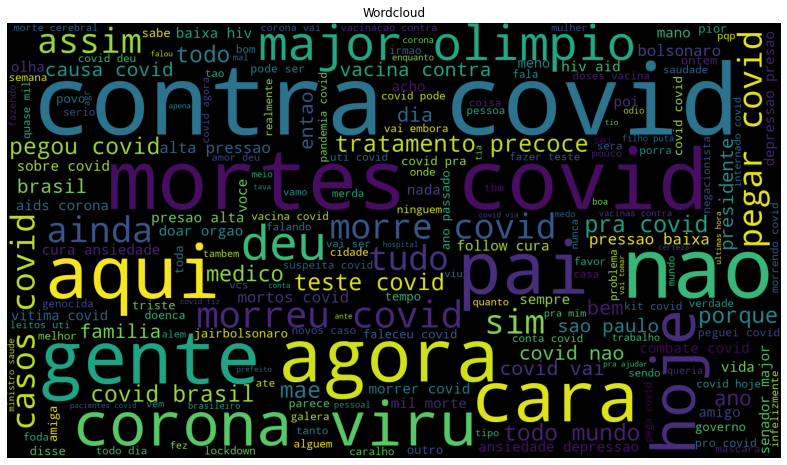

In [42]:
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
plt.title('Wordcloud')

## Clusterização

In [43]:
df_cluster = df_tweets.copy()

In [44]:
df_cluster['text_tokenized'] = df_cluster['text'].apply(tt.tokenize)

In [45]:
df_cluster['text_tokenized']

1          [nao, esquecam, nova, concepcao, oms, sobre, c...
4          [desgraca, covid, volta, toda, forca, recife, ...
5          [acabei, ver, video, politicos, maria, falando...
9                 [dia, propicio, pra, beber, covid, acabar]
10         [esse, mofino, presume, governadores, prefeito...
                                 ...                        
1374586                [mae, vai, fazer, teste, covid, medo]
1374587         [agora, nunca, odio, covid, quero, ver, meu]
1374588                 [gente, ficando, medo, covid, antes]
1374591    [chocada, real, porque, parei, pra, pesquisar,...
1374596    [bizarro, ver, dias, hoje, ainda, gente, acha,...
Name: text_tokenized, Length: 460755, dtype: object

In [46]:
#converte as palavras para seu radical 
stemmer = nltk.stem.RSLPStemmer()

df_cluster['text_cluster'] = df_cluster['text_tokenized'].map(lambda x: ' '.join([stemmer.stem(word) for word in x]))

## TF-IDF - Importância relativa das palavras

In [47]:
df_sample_cluster = df_cluster.sample(25000)

In [48]:
df_sample_cluster.to_csv('data/base_amostral.csv')

In [7]:
vectorizer = TfidfVectorizer(stop_words=portuguese_stops)
features = vectorizer.fit_transform(df_sample_cluster['text_cluster'])

## Definição do número de clusters

In [8]:
distortions = []

K = range(1,20)

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

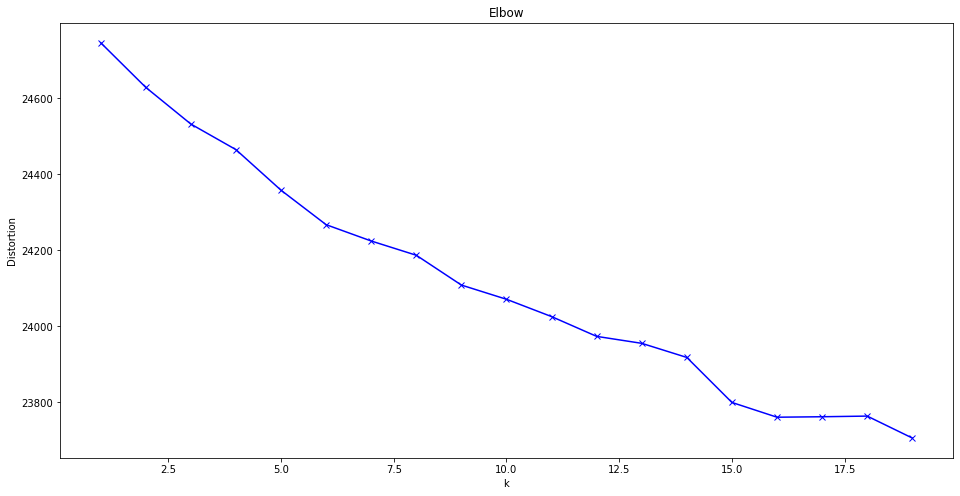

In [9]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow')
plt.show()

## Criação dos clusters

In [10]:
cls = MiniBatchKMeans(n_clusters=9, random_state=5)
cls.fit(features)
cls.predict(features)
cls.labels_

array([3, 7, 2, ..., 3, 3, 2], dtype=int32)

In [11]:
pca = PCA(n_components=2, random_state=5)
reduced_features = pca.fit_transform(features.toarray())
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

In [12]:
cls.predict(features)

array([3, 7, 2, ..., 3, 3, 2], dtype=int32)

In [13]:
colormap = np.array(['purple', 
                     'green', 
                     'red', 
                     'yellow', 
                     'blue', 
                     'pink',
                     'orange',
                     'black',
                     'tan',
                     'aquamarine'])

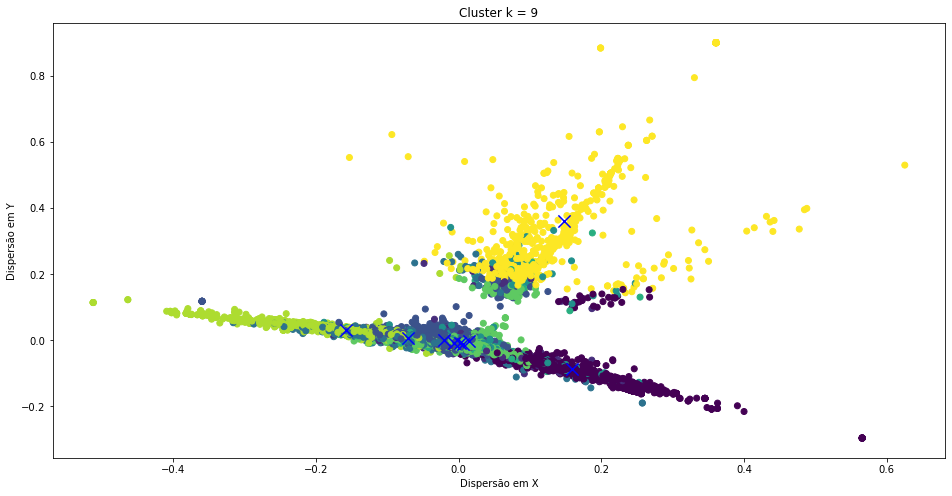

In [14]:
plt.figure(figsize=(16,8))
plt.title("Cluster k = %d" % 9)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

### Definição do Cluster para cada Tweet

In [18]:
def get_cluster_number(tweet):
    X = vectorizer.transform(tweet)
    predicted = cls.predict(X)
    return predicted[0]

In [31]:
df_sample_cluster['cluster_number'] = df_sample_cluster['text_cluster'].apply(lambda tweet: get_cluster_number([tweet]))

In [32]:
df_cluster_most = pd.DataFrame()

clusters = 9 
positions = 10

for cluster in range(0,clusters):
    for position in range(0,positions):
        df_cluster = df_sample_cluster.loc[df_sample_cluster['cluster_number'] == cluster]
        list_freq = get_most_frequently(df_cluster["text"])
        
        word = ''
        
        if(len(list_freq) > position):
            word = list_freq[position][0]   
            
        df_cluster_most.loc[position, 'cluster_' + str(cluster)] = word

In [ ]:
df_cluster_most